In [30]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

!pip -q install datasets
from datasets import load_dataset

from PIL import Image

IMG = 128


In [31]:
import zipfile
import os

# Extract the zip file
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall('fer2013_data')

# Check the folder structure to ensure paths are correct
print(os.listdir('fer2013_data'))

['test', 'train']


In [32]:
def load_local_data(directory):
    X = []
    y = []
    # Get the names of the folders (labels)
    label_names = sorted(os.listdir(directory))

    for label_idx, label_name in enumerate(label_names):
        folder_path = os.path.join(directory, label_name)
        if not os.path.isdir(folder_path):
            continue

        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            try:
                # Load, convert to RGB, and resize to 48x48
                img = Image.open(img_path).convert('RGB').resize((IMG, IMG))
                X.append(np.array(img, dtype=np.float32))
                y.append(label_idx)
            except Exception as e:
                print(f"Skipping {img_path}: {e}")

    return np.stack(X), np.array(y), label_names

# Set paths based on your extracted folder structure
# Usually: 'fer2013_data/train' and 'fer2013_data/test'
X_train, y_train, label_names = load_local_data('fer2013_data/train')
X_val, y_val, _ = load_local_data('fer2013_data/test')

print("Labels:", label_names)

# MobileNetV2 preprocessing
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)

# One-hot encoding
y_train = to_categorical(y_train, num_classes=len(label_names))
y_val = to_categorical(y_val, num_classes=len(label_names))

Labels: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [33]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("Labels:", label_names)

X_train shape: (28709, 128, 128, 3)
y_train shape: (28709, 7)
X_val shape: (7178, 128, 128, 3)
y_val shape: (7178, 7)
Labels: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [34]:
base_model = MobileNetV2(input_shape=(IMG, IMG, 3), include_top=False, weights='imagenet')

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


9406464/9406464 [==============================] - 2s 0us/step


In [35]:
from sklearn.utils import class_weight
import numpy as np

# Calculate weights based on y_train labels (before one-hot encoding)
# If y_train is one-hot, use np.argmax(y_train, axis=1)
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1)
)

class_weights_dict = dict(enumerate(weights))

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Define the augmentation parameters
train_datagen = ImageDataGenerator(
    rotation_range=20,      # Randomly rotate images
    width_shift_range=0.2,  # Shift images horizontally
    height_shift_range=0.2, # Shift images vertically
    shear_range=0.2,        # Shear transformations
    zoom_range=0.2,         # Randomly zoom in
    horizontal_flip=True,   # Flip faces horizontally
    fill_mode='nearest'
)

# 2. Apply it to your training data (X_train is already preprocessed)
train_generator = train_datagen.flow(X_train, y_train, batch_size=16)

from sklearn.utils import class_weight

# Calculate weights to balance the classes
y_integers = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_integers),
    y=y_integers
)
class_weights_dict = dict(enumerate(class_weights))



In [37]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True)
]

In [38]:
# 3. Use train_generator in model.fit instead of (X_train, y_train)
history_1 = model.fit(
    train_generator, # <--- Change this
    validation_data=(X_val, y_val),
    epochs=10,
    class_weight=class_weights_dict, # <--- Add this line here
    shuffle=True,
    callbacks=callbacks
)

Epoch 1/10
1795/1795 [==============================] - 376s 208ms/step - loss: 1.8003 - accuracy: 0.2725 - val_loss: 1.5923 - val_accuracy: 0.3994
Epoch 2/10
1795/1795 [==============================] - 392s 218ms/step - loss: 1.6949 - accuracy: 0.3256 - val_loss: 1.5732 - val_accuracy: 0.3959
Epoch 3/10
1795/1795 [==============================] - 478s 266ms/step - loss: 1.6679 - accuracy: 0.3344 - val_loss: 1.5602 - val_accuracy: 0.3937
Epoch 4/10
1795/1795 [==============================] - 447s 249ms/step - loss: 1.6516 - accuracy: 0.3455 - val_loss: 1.4939 - val_accuracy: 0.4469
Epoch 5/10
1795/1795 [==============================] - 453s 252ms/step - loss: 1.6415 - accuracy: 0.3499 - val_loss: 1.4868 - val_accuracy: 0.4315
Epoch 6/10
1795/1795 [==============================] - 451s 251ms/step - loss: 1.6231 - accuracy: 0.3551 - val_loss: 1.5242 - val_accuracy: 0.4388
Epoch 7/10
1795/1795 [==============================] - 437s 244ms/step - loss: 1.6197 - accuracy: 0.3618 - val_

In [41]:
for layer in base_model.layers[-10:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # Tiny learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_2 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,           # total epochs (10 + 10 more)
    initial_epoch=10,
    class_weight=class_weights_dict, # Fixes class imbalance
    batch_size=16,
    shuffle=True,
    callbacks=callbacks
)


Epoch 11/25
1795/1795 [==============================] - 290s 160ms/step - loss: 1.2506 - accuracy: 0.4990 - val_loss: 1.2583 - val_accuracy: 0.5265
Epoch 12/25
1795/1795 [==============================] - 356s 199ms/step - loss: 1.2199 - accuracy: 0.5081 - val_loss: 1.2924 - val_accuracy: 0.5152
Epoch 13/25
1795/1795 [==============================] - 267s 149ms/step - loss: 1.2057 - accuracy: 0.5117 - val_loss: 1.2563 - val_accuracy: 0.5284
Epoch 14/25
1795/1795 [==============================] - 268s 149ms/step - loss: 1.1819 - accuracy: 0.5183 - val_loss: 1.2504 - val_accuracy: 0.5312
Epoch 15/25
1795/1795 [==============================] - 272s 152ms/step - loss: 1.1551 - accuracy: 0.5343 - val_loss: 1.2422 - val_accuracy: 0.5355
Epoch 16/25
1795/1795 [==============================] - 762s 425ms/step - loss: 1.1307 - accuracy: 0.5359 - val_loss: 1.2259 - val_accuracy: 0.5404
Epoch 17/25
1795/1795 [==============================] - 273s 152ms/step - loss: 1.1129 - accuracy: 0.5439

In [42]:
import os

model_path = "emotion_recognition_model.keras"

# Check if the file exists, and if so, delete it
if os.path.exists(model_path):
    os.remove(model_path)
    print(f"Existing model '{model_path}' deleted.")

# Save the new model
model.save(model_path)
print(f"New model saved as '{model_path}'.")

New model saved as 'emotion_recognition_model.keras'.


In [43]:
emotion_labels = {i: name.capitalize() for i, name in enumerate(label_names)}
print(emotion_labels)


{0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}


In [44]:
y_pred = model.predict(X_val)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_val, axis=1)


225/225 [==============================] - 42s 182ms/step


In [45]:
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_true_labels, y_pred_labels))
print("\nClassification Report:")
print(classification_report(
    y_true_labels,
    y_pred_labels,
    target_names=[emotion_labels[i] for i in range(len(emotion_labels))],
    digits=2
))

Accuracy: 0.5628308721092227

Classification Report:
              precision    recall  f1-score   support

       Angry       0.45      0.48      0.47       958
     Disgust       0.41      0.67      0.51       111
        Fear       0.45      0.34      0.38      1024
       Happy       0.77      0.74      0.76      1774
     Neutral       0.48      0.55      0.51      1233
         Sad       0.48      0.42      0.45      1247
    Surprise       0.64      0.79      0.71       831

    accuracy                           0.56      7178
   macro avg       0.53      0.57      0.54      7178
weighted avg       0.56      0.56      0.56      7178



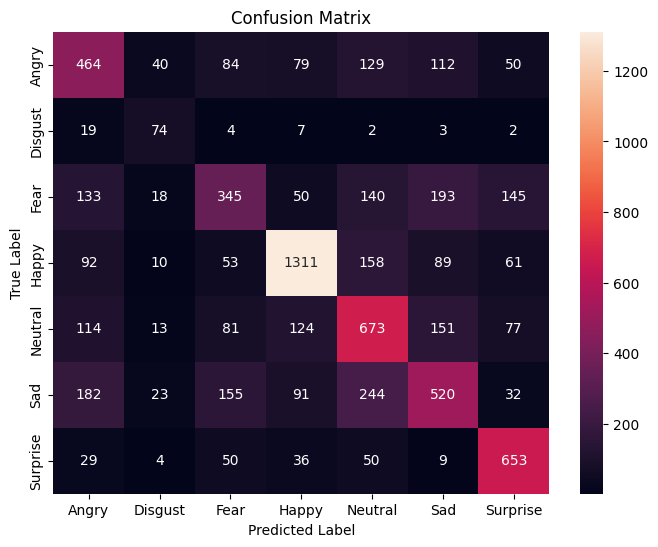

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=[emotion_labels[i] for i in range(len(emotion_labels))],
    yticklabels=[emotion_labels[i] for i in range(len(emotion_labels))],
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



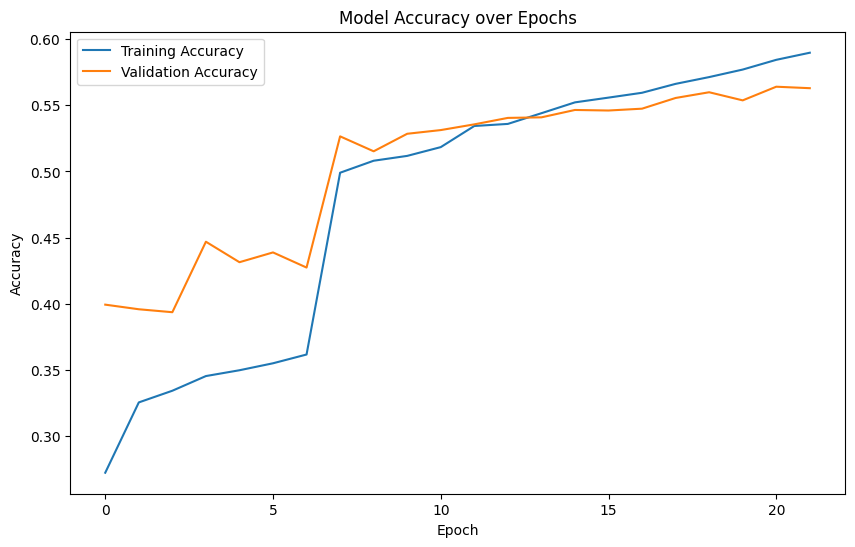

In [47]:
train_acc = history_1.history['accuracy'] + history_2.history['accuracy']
val_acc   = history_1.history['val_accuracy'] + history_2.history['val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


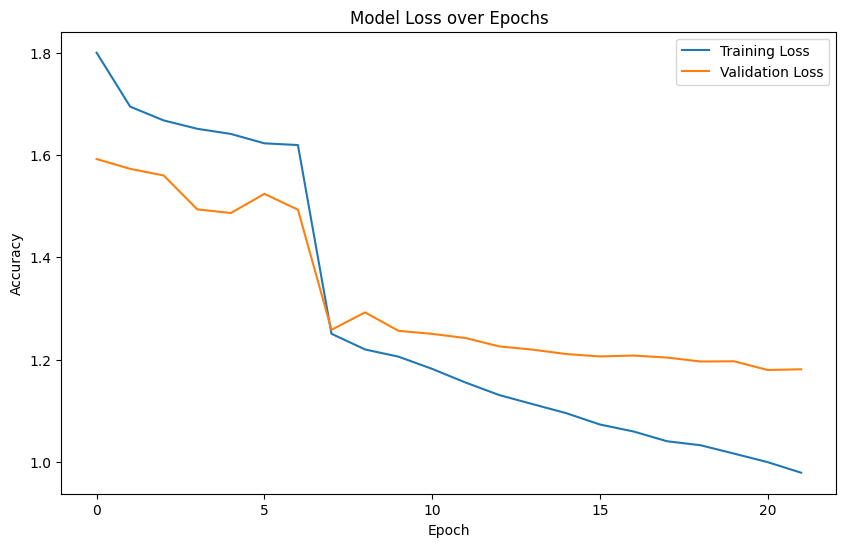

In [48]:
train_loss = history_1.history['loss'] + history_2.history['loss']

val_loss   = history_1.history['val_loss'] + history_2.history['val_loss']

plt.figure(figsize=(10,6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()